## Table of content

* [Approach](#approach)
* [1. Imports](#imports)
* [2. Open File](#open)
* [3. Book Recommendation System for Toddlers](#recom_desc)
    * [3.1. Find Board Books](#board)
    * [3.2.  Clean and Lemmatize Book Description](#clean_desc)
    * [3.3.   Recommendation System for Toddlers: based on book description](#function)
* [4. Book Recommendation System for Teenagers Based on Book Reviews](#reviews)
    * [4.1. Find Teenage Books](#kid)
    * [4.2. Drop Books with No Positive Reviews](#drop)
    * [4.3. Topic Extraction](#topic)
        * [4.3.1.  Find Vey Common Words in Reviews and Drop Them](#common)
        * [4.3.2. Clean the Reviews](#clean_review)
        * [4.3.3. Extract Verbs from Reviews](#verbs)
        * [4.3.4. Extract Topics Using Non-Negative Matrix Factorization](#nmf)
        * [4.3.5. Classify Books](#clasify)
* [5. Summary](#summary)

## Approach <a anchor='class' id='approach'>

In Data wrangling notebook we prepared our data. In this notebook we built book recommendation systems. The first is for toddlers and the second one is for older kids. Here are the steps we will take:

For toddler books:
1. Search for toddler books by using book descriptions
2. Clean book descriptions by eliminate stop words and then stem and lemmatize them
3. Use TF-IDF and cosine similarity to determine the similarity between books
4. Test the system by giving it a title and see the result

For teenagers and older kilds:
1. Search for kids books by eliminating toddler's books
2. Do a quick EDA on reviews and drop the books with very long/short reviews
3. Create a list of most common words used in reviews
4. Clean the reviews by eliminating stopwords as well as highly used words found in the previous step
5. Extract verbs from each book review
6. Create vectors of the extracted verbs for each book
7. Extract topics from reviews and get a list of the common words in each topic 
8. Interprete topics 
9. Tag books with a topic 




## 1. Imports <a class='anchor' id='imports'>

In [582]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
nltk.download('wordnet')

from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Open File <a class='anchor' id='open'>

In [583]:
path = 'C:\\Users\\somfl\\Documents\\GitHub\\Somayeh_Youssefi\\Book Recomendation System\\data_files\\CleanedBooks.csv'
df = pd.read_csv(path, sep=',')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
0,287141,1599150603,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",162.0,"[{'author_id': '3041852', 'role': ''}]",46.0,4.13,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/287141.The...,[],Alfred J. Church,"{'history, historical fiction, biography': 9, ...","Once again, my kids loved this book about anci...",NaN
1,6066812,1934876569,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",216.0,"[{'author_id': '19158', 'role': ''}]",98.0,4.22,https://images.gr-assets.com/books/1316637798m...,https://www.goodreads.com/book/show/6066812-al...,"['948696', '439885', '274955', '12978730', '37...",['Rachel Roberts'],"{'fantasy, paranormal': 32, 'young-adult': 8, ...",NaN,"This was a really cute book, though to be hone..."
2,89378,0590417010,Dog Heaven,In Newbery Medalist Cynthia Rylant's classic b...,40.0,"[{'author_id': '5411', 'role': ''}]",1331.0,4.43,https://images.gr-assets.com/books/1360057676m...,https://www.goodreads.com/book/show/89378.Dog_...,"['834493', '452189', '140185', '1897316', '218...",['Cynthia Rylant'],"{'children': 109, 'fiction': 13, 'non-fiction'...","Really cute, sweet, and charming.,This beautif...",I probably would have liked this book more if ...
3,1698376,1416904999,What Do You Do?,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,24.0,"[{'author_id': '169159', 'role': ''}]",23.0,3.57,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1698376.Wh...,[],['Mandy Stanley'],{'children': 6},NaN,Colourful. Fun to read. My daughter enjoys thi...
4,3631900,0884482987,Amadi's Snowman: A Story of Reading,When Amadi disobeys his mother and runs off to...,32.0,"[{'author_id': '1540277', 'role': ''}, {'autho...",44.0,3.89,https://images.gr-assets.com/books/1300370678m...,https://www.goodreads.com/book/show/3631900-am...,[],"['Katia Novet Saint-Lot', 'Dimitrea Tokunbo']","{'fiction': 6, 'children': 8, 'young-adult': 1}",My nine-year-old son and I enjoyed this book a...,"This is an enjoyable book, and Amadi is an eng..."


In [603]:
df.dropna(subset=['description'], axis=0, inplace = True)
df = df.reset_index().drop(columns='index')

In [605]:
df.isna().sum()

book_id                0
isbn                4542
title                  0
description            0
num_pages              0
authors                0
ratings_count          0
average_rating         0
image_url              0
url                    0
similar_books          0
authors_names          0
genres                 0
positive_review    10638
negative_review    22768
dtype: int64

In [661]:
df.drop_duplicates(subset=['title'], keep='first', inplace = True)
df = df.reset_index().drop(columns='index')

## 3. Book Recommendation System for Toddlers <a class='anchor' id='recom_desc'>

### 3.1.  Find Board Books <a class='anchor' id='board'>

In [680]:
# Let's see how many board books we have:
board_book_list = []
for i in range(len(df)):
    text = df.loc[i, 'description'].lower()
    if ((re.search('board book', text)) or (re.search('sensory', text)) or (re.search('touch', text)) or (re.search('flap',text))
    or (re.search('new reader', text)) or (re.search('teach color', text)) or (re.search('teach numbers', text)) 
    or (re.search('teach color', text)) or (re.search('infant', text)) or (re.search('toddler', text)) or (re.search('baby', text))
    or (re.search('illustration', text) and re.search('toddler', text)) or (re.search('picture', text) and re.search('toddler', text))
    or (re.search('illustration', text) and re.search('baby', text)) or (re.search('picture', text) and re.search('toddler', text))
       or (re.search('sesame street', text)) or (re.search('dr. seuss', text))):
        board_book_list.append(df.loc[i,'book_id'])

In [691]:
mask = df['book_id'].isin(board_book_list)
df_board_book = df[mask]
df_board_book = df_board_book.reset_index()


In [692]:
df_board_book.shape

(4937, 16)

In [693]:
df_board_book.isna().sum()

index                 0
book_id               0
isbn                238
title                 0
description           0
num_pages             0
authors               0
ratings_count         0
average_rating        0
image_url             0
url                   0
similar_books         0
authors_names         0
genres                0
positive_review     797
negative_review    2002
dtype: int64

### 3.2.  Clean and Lemmatize Book Description <a class='anchor' id='clean_desc'>

In [694]:
# Let's define a function to clean the text

def clean_function (text):

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove non-ASCII characheters
    
    text = "".join(i for i in text if  ord(i)<128)
    
    # change to lower case
    text = text.lower()

    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    contractions = { 
    "ain't": "am not","aint": "am not",
    "aren't": "are not","arent": "are not",
    "can't": "cannot","cant": "cannot",
    "can't've": "cannot have","cant've": "cannot have",
    "'cause": "because",
    "could've": "could have","couldve": "could have",
    "couldn't": "could not","couldnt": "could not",
    "couldn't've": "could not have","couldnt've": "could not have",
    "didn't": "did not","didnt": "did not",
    "doesn't": "does not","doesnt": "does not",
    "don't": "do not","dont": "do not",
    "hadn't": "had not","hadnt": "had not",
    "hadn't've": "had not have","hadnt've": "had not have",
    "hasn't": "has not","hasnt": "has not",
    "haven't": "have not","havent": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would","id": "i would",
    "i'll": "i will",
    "i'm": "i am","im": "i am",
    "i've": "i have","ive": "i have",
    "isn't": "is not","isnt": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not","mustnt": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is","thats": "that is",
    "there'd": "there had",
    "there's": "there is","theres": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
    }  

    text = word_tokenize(text)
    # Replace contractions with their longer forms 
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
        
    # Removing english stopwords 
    text = remove_stopwords(text)

    return text

In [695]:
# Lemmatize and stemming

def preprocess(text):
    text = word_tokenize(text)
    result = []
    for word in text:

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        lemm = nltk.stem.WordNetLemmatizer().lemmatize(word, tag_dict.get(tag, wordnet.NOUN))
        
        stemmer = SnowballStemmer('english')
        stemm = stemmer.stem(lemm)
        result.append(stemm)
    result = " ".join(result)
    return result
        

In [696]:
# Let's clean and lemmatize description

df_board_book['clean_desc'] = df_board_book['description'].apply(clean_function)
df_board_book['lem_clean_desc'] = df_board_book['clean_desc'].apply(preprocess)

### 3.3.   Recommendation System for Toddlers: based on book description <a class='anchor' id='function'>

In [700]:
# Function for recommending books based on Book description. It takes book title as input:
def recomm_title(book_title):

    indx = pd.Series(df_board_book.index, index = df_board_book['title'])

    #Converting the book discription into vectors
    tfModel = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words='english')
    tfidf_vector = tfModel.fit_transform(df_board_book['lem_clean_desc'])
    
    # Estimate the similarity of book description based on Cosine Similarity
    similarity_matrix = cosine_similarity(tfidf_vector, tfidf_vector)
    
    # Get the index corresponding to original_title
       
    idx = indx[book_title]# Get the pairwsie similarity scores 
    similar_books = sorted(list(enumerate(similarity_matrix[idx])), key=lambda x: x[1], reverse=True)
    Top_five_similar_books = similar_books[1:6]# Book indicies
    book_indices = [i[0] for i in Top_five_similar_books]
   
    # Top 10 book recommendation
    recommendation = df_board_book[['title', 'authors_names']].iloc[book_indices]
       
    # It reads the top 5 recommended book urls and print the images
    

    return recommendation

In [701]:
recomm_title('Baby Sea Otter')

,title,authors_names
2475,Otters Love to Play,"['Jonathan London', 'Meilo So']"
1476,"Good Night, Little Sea Otter","['Janet Halfmann', 'Wish Williams']"
1872,Baby Otter,"['Ginjer L. Clarke', 'Robbin Cuddy']"
2326,A Lot of Otters,['Barbara Helen Berger']
4263,Otter Loves Halloween,['Sam Garton']


## 4. Book Recommendation System for Teenagers Based on Book Reviews <a class='anchor' id='reviews'>

Let's find the books for kids. We will drop the toddlers' books from datafarme. We then drop the books with empty positive reviews. Then we look at the length of reviews and only keep those with words between 1000 to 5000. There are some words with so many reviews such as Harry Potter series, which will affect the topic extraction.

Non- will be used to etract topics. This methods outperforms LDA.

### 4.1. Find Teenager Books <a class='anchor' id='kid'>

In [782]:
# df_kid_book
non_kid_list = board_book_list 
mask = ~df['book_id'].isin(set(non_kid_list))
df_kid_book = df[mask]
df_kid_book = df_kid_book.reset_index()
df_kid_book.drop(['index'], axis=1, inplace=True)

df_kid_book.shape

(42279, 15)

In [783]:
df_kid_book.isna().sum()

book_id                0
isbn                2849
title                  0
description            0
num_pages              0
authors                0
ratings_count          0
average_rating         0
image_url              0
url                    0
similar_books          0
authors_names          0
genres                 0
positive_review     7680
negative_review    16416
dtype: int64

### 4.2. Drop Books with No Positive Reviews <a class='anchor' id='drop'>

In [784]:
df_kid_book.dropna(subset=['positive_review'], axis=0, inplace=True)

In [785]:
## let's check the length of reviews
def splitt(text):
    text = text.split()
    return len(text)

df_kid_book['review_length'] = df_kid_book['positive_review'].apply(splitt)

Text(0.5, 1.0, 'Distribution of number of words in reviews')

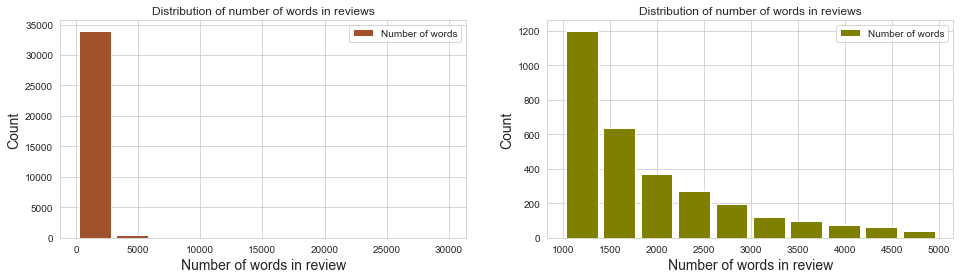

In [787]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
df_kid_book['review_length'].plot.hist(bins=10, rwidth=0.85, color="sienna", ax=ax0)
df_kid_book.loc[(df_kid_book['review_length']<5000)&(df_kid_book['review_length']>1000)]['review_length'].plot.hist(bins=10, rwidth=0.85, color="olive", ax=ax1)

ax0.legend(['Number of words'])
ax0.set_xlabel('Number of words in review', fontsize=14)
ax0.set_ylabel('Count', fontsize=14)
ax0.set_title('Distribution of number of words in reviews')
ax1.legend(['Number of words'])
ax1.set_xlabel('Number of words in review', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Distribution of number of words in reviews')

In [788]:
# Focus on books with revews of 1000 to 5000 words!

long_review_list = df_kid_book.loc[(df_kid_book['review_length']>1000) & (df_kid_book['review_length']<5000), 'book_id']
mask = df_kid_book['book_id'].isin(long_review_list)
df_kid_book = df_kid_book[mask]
df_kid_book = df_kid_book.reset_index()
df_kid_book.drop(['index'], axis=1, inplace=True)
df_kid_book.shape

(3065, 16)

## 4.3. Topic Extraction <a class='anchor' id='topic'>

### 4.3.1.  Find Vey Common Words in Reviews and Drop Them <a class='anchor' id='common'>

In [789]:
tfModel = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 1), min_df = 100)

data_cv = tfModel.fit_transform(df_kid_book['positive_review'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=tfModel.get_feature_names())
data_dtm.index = df_kid_book.index
data_dtm_copy = data_dtm
word_df = pd.DataFrame(data_dtm.sum())
word_df = word_df.sort_values(by = 0, ascending = False)
print(word_df.shape)

(2585, 1)


In [790]:
word_df.head(20)

,0
book,585.393881
story,282.484574
read,239.275042
children,164.950505
illustrations,156.320651
like,141.719194
love,138.892831
great,136.971029
books,136.645886
series,122.068984


In [791]:
# Define a function to remove the highly common words from reviews

custom_stop_words = []
custom_stop_words = word_df[0:40].index 
custom_stop_words = list(custom_stop_words)
custom_stop_words =  custom_stop_words + ['families', 'years', 'reader', 'illustration', 'picture']

def custom_clean(text):
    text = text.split()
    stops = custom_stop_words 
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

### 4.3.2. Clean the Reviews <a class='anchor' id='clean_reveiew'>

In [792]:
# Clean the positive reviews by using the initial clean function as well as the custom function

df_kid_book['first_round'] = df_kid_book['positive_review'].apply(clean_function)
df_kid_book['second_round'] = df_kid_book['first_round'].apply(custom_clean)


### 4.3.3. Extract Verbs from Reviews <a class='anchor' id='verbs'>

In [793]:
# Define a function that gets the verb in a given string of words for topic extraction

def verbs(text):
    '''Given a string of text, tokenize the text and pull out only the the verbs.'''
    is_verb = lambda pos: pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    verbs = [word for (word, pos) in pos_tag(tokenized) if is_verb(pos)] 
    return ' '.join(verbs)

### 4.3.4. Extract Topics Using Non-Negative Matrix Factorization <a class='anchor' id='nmf'>

In [800]:
# Apply function to reviews ro remove verbs
data_verbs = pd.DataFrame(df_kid_book['second_round'].apply(verbs))

# Vectorize each document
tv_verb = TfidfVectorizer(ngram_range = (1,1), min_df = 1)
data_tv_verb = tv_verb.fit_transform(data_verbs['second_round'])

# Classification with NMF 
nmf_model = NMF(15)
doc_topic = nmf_model.fit_transform(data_tv_verb)

components_df = pd.DataFrame(nmf_model.components_, columns=tv_verb.get_feature_names())

# Display topics
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')
                                                


For topic 1 the words with the highest value are:
wants      1.216410
gets       0.613095
want       0.483725
makes      0.432885
comes      0.387630
loves      0.379529
goes       0.378403
bear       0.341607
play       0.340476
getting    0.307598
trying     0.302244
going      0.283833
finds      0.283132
bed        0.275747
takes      0.266441
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
rhyming        2.142810
rhymes         0.266392
rhyme          0.196163
illustrated    0.129045
bright         0.122324
bed            0.114897
received       0.111154
makes          0.106581
sleep          0.085485
written        0.081093
charming       0.081022
rhymed         0.080422
sleeping       0.079140
sing           0.078764
engaging       0.078730
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
rose        1.943049
booke       0.072190
devoted     0.054403
weaving     0.047953
wilder      0.047528
talking     0.046172
diana       

In [801]:
doc_topics = pd.DataFrame(doc_topic, index = df_kid_book.index)
doc_topics['topic_number'] = doc_topics.idxmax(axis=1)


### 4.3.5.  Classify Books <a class='anchor' id='classify'>

In [808]:
labels = ['planning', 'rhyming_and_singing', 'love_and_family', 'fiction', 'teaching', 'inspirational', 'memories', 'history',
          'animals', 'bullying', 'poetry', 'missing_loved_ones','teach_maths','Christmas_tories', 'animals_and_nature']

In [809]:
topics_dic = {}
for i in range(len(labels)):
    topics_dic[i] = labels[i]
for i in range(len(doc_topics)):
    x = doc_topics.loc[i, 'topic_number']
    doc_topics.loc[i, 'label'] = topics_dic[x]
topics_book = doc_topics['label']
kid_books = df_kid_book.merge(topics_book, left_index=True, right_index=True)

Let's get 3 recommendations for books to practice maths.

In [812]:
kid_books.loc[kid_books['label']=='teach_maths'].head(1)

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review,review_length,first_round,second_round,label
3,1076040,069001287X,Anno's Counting Book,"Every child is a natural mathematician, accord...",28.0,"[{'author_id': '72077', 'role': ''}]",551.0,4.06,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1076040.An...,"['289881', '6516912', '1873420', '282631', '21...",['Mitsumasa Anno'],"{'children': 96, 'non-fiction': 6, 'fiction': 4}",Genre: Counting \n Summary: A wordless picture...,Awesome description and intro. to math for you...,1368,genre counting summary wordless picture book d...,genre counting summary wordless depicts notion...,teach_maths


## 5. Summary <a class='anchor' id='summary'>


In this notebook we built book recommendation systems for both toddlers and older kids. We first find books appropriate for each group and then build our systems.

Each row in our data frame contains information of a book. these data includes 1) title, 2) description 3) all positive reviews (as a joined string) 4) all negative reviews (as a long string)

For toddler books, we built the recommendation system based on _book description_ and these are the steps we took:

1. Cleaned book descriptions by eliminating stop words and then stemmed and lemmatized book descriptions
2. creates vectors of words and found the frequency of each word in each description
3. Determined the similarity of book descriptions based on word frequency
4. Tested the system several times by giving it a title and see the result

The system works great. It can be due to the comprehensive descriptions as well as our approach.


For teenagers and older kilds:

1. Created a list of most common words used in reviews
2. Cleaned the reviews by eliminating stopwords as well as highly used words found in the previous step
3. Extracted verbs from each book review
4. Created vectors of the extracted verbs for each book
5. Extracted topics from reviews and get a list of the common words in each topic
6. Interpreted topics and then tagged each book with its topic label
7. Tested the sytem 

The kids book works fine not as well as the previous system.
